<a href="https://colab.research.google.com/github/serdarbozoglan/My_NLP/blob/master/Sentiment_Analysis_BERT_PyTorch_hugginghface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 38.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 19.7MB/s]


In [5]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


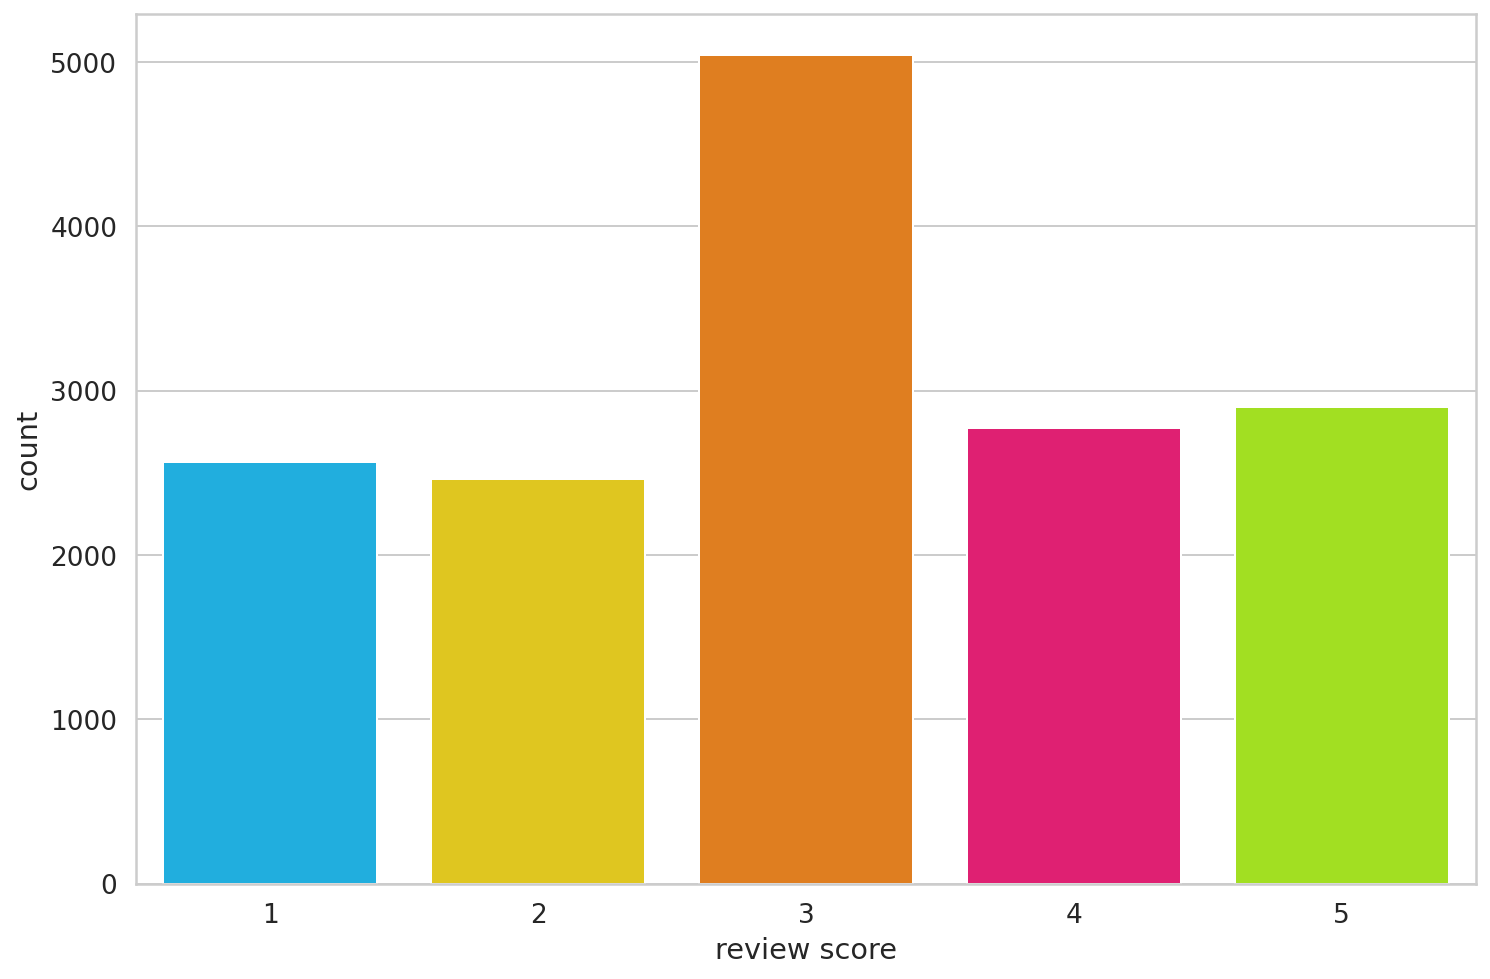

In [8]:
sns.countplot(df.score)
plt.xlabel('review score');

In [0]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2 :
        return 0
    if rating == 3:
        return 1
    else:
        return 2

In [0]:
df['sentiment'] = df['score'].apply(to_sentiment)

In [11]:
df['sentiment'].value_counts(normalize=True)

2    0.360473
1    0.320208
0    0.319319
Name: sentiment, dtype: float64

In [0]:
class_names =['negative', 'neutral', 'positive']

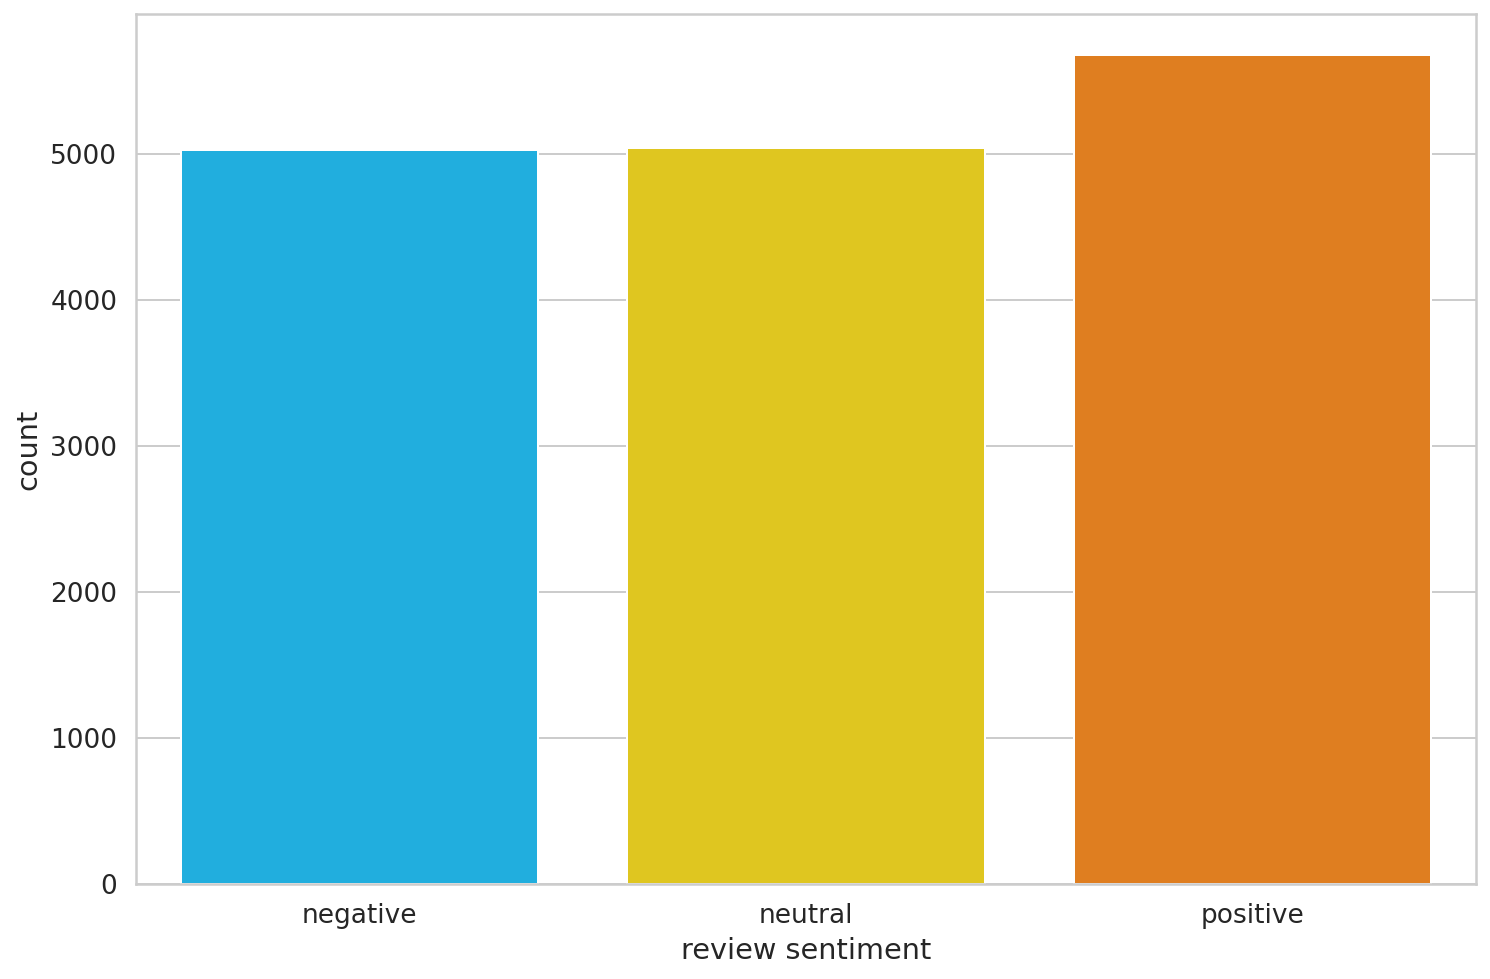

In [13]:
ax = sns.countplot(df['sentiment'])
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # we're using cased version. For sentiment analysis case may matter
# For example "BAD" may more strong meaning than "bad" in text

In [0]:
## Data Preprocessing

In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [18]:
tokens = tokenizer.tokenize(sample_txt)
print(tokens)

['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [19]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [20]:
print(f'Sentence : {sample_txt}')
print(f'  Tokens : {tokens}')
print(f'Token ids: {token_ids}')

Sentence : When was I last outside? I am stuck at home for 2 weeks.
  Tokens : ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token ids: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [0]:
### Special Tokens

In [21]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [31]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [32]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [33]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [22]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

# To retunrn for pytorch we need to return tensors 'pt' for keras it should be 'tf' (tensorflow)

dict_keys(['input_ids', 'attention_mask'])

In [23]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [24]:
# Attention masks input id 0 olamyan yani pad olmamis her token icin 1, pad edilmis olanlar icin 0 dondurur
encoding['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [0]:
token_lens = []

for txt in df['content']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

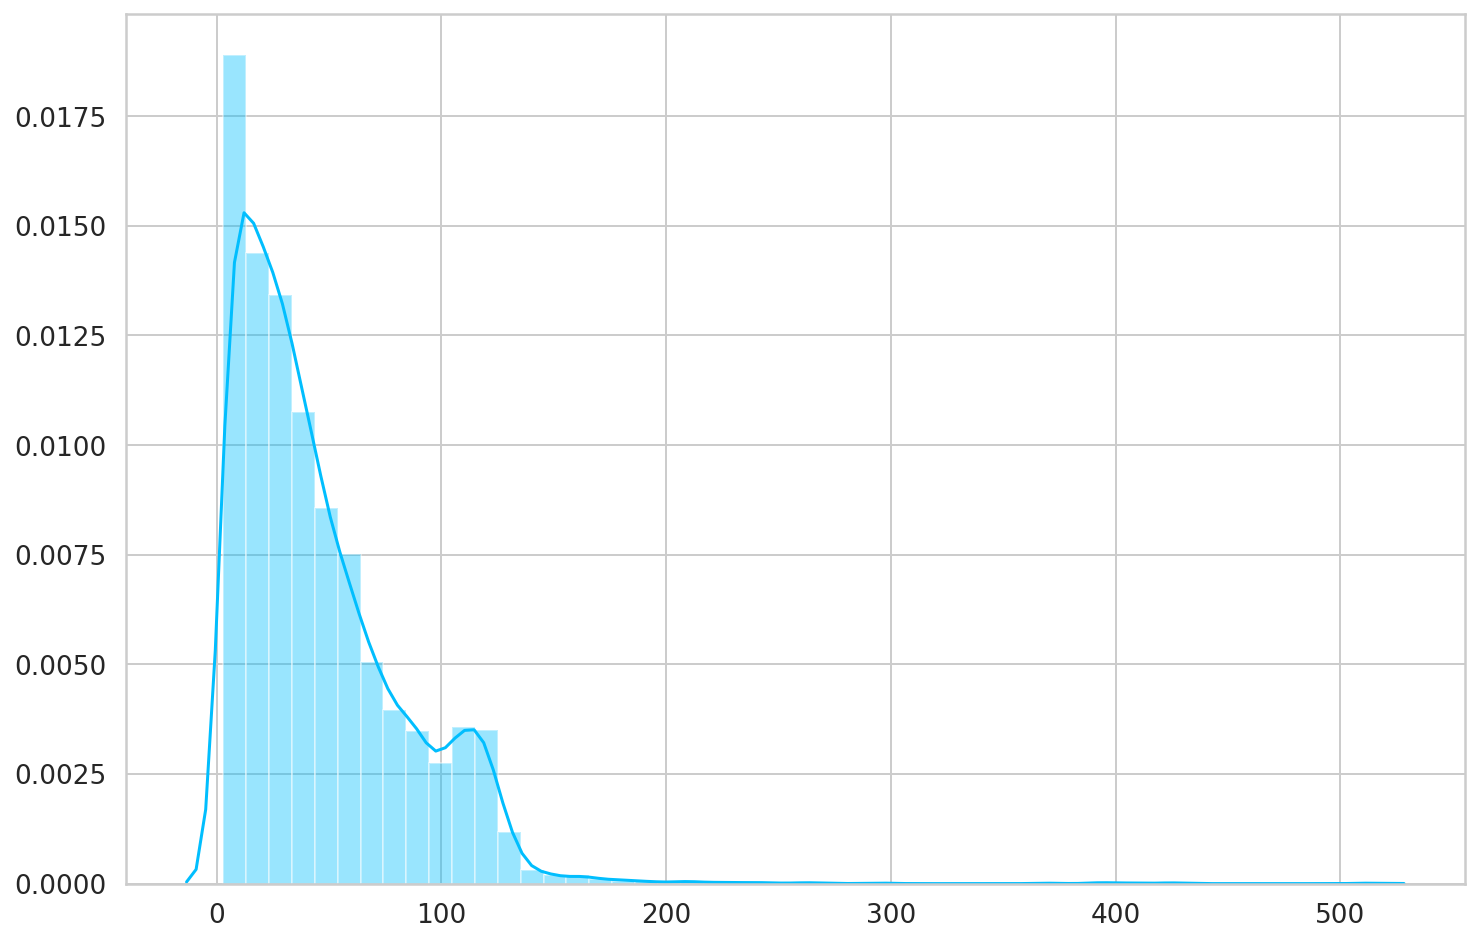

In [27]:
sns.distplot(token_lens);

In [0]:
### Create a dataset

In [0]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [0]:
# Google Play Review Dataset 
class GPReviewDataset(Dataset): 

    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    
    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            pad_to_max_length = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'  # Return PyTorch tensors
            )

        return {
        'review_text':review,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.target[item], dtype=torch.long)}


In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [40]:
df_train.shape, df_val.shape, df_test.shape


((12596, 12), (1575, 12), (1575, 12))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review = df['content'].to_numpy(),
        target = df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [0]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [43]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [44]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [45]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
last_hidden_state, pooled_output = bert_model(
                                            input_ids=encoding['input_ids'], 
                                            attention_mask=encoding['attention_mask'])

In [48]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [49]:
pooled_output.shape

torch.Size([1, 768])

In [50]:
bert_model.config.hidden_size

768

In [0]:
### Building Sentiment Classifier

In [0]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        output = self.out(output)

        return self.softmax(output)        

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [60]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device) 

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [61]:
model(input_ids, attention_mask)

tensor([[0.4628, 0.2880, 0.2492],
        [0.6311, 0.1592, 0.2097],
        [0.2466, 0.1770, 0.5764],
        [0.6049, 0.1859, 0.2092],
        [0.6481, 0.1046, 0.2473],
        [0.5419, 0.1357, 0.3224],
        [0.5206, 0.2033, 0.2762],
        [0.5602, 0.1970, 0.2428],
        [0.4928, 0.1195, 0.3878],
        [0.5076, 0.1428, 0.3496],
        [0.7718, 0.1092, 0.1189],
        [0.5416, 0.1418, 0.3166],
        [0.5192, 0.1296, 0.3513],
        [0.4784, 0.1516, 0.3700],
        [0.4868, 0.1250, 0.3881],
        [0.6614, 0.1160, 0.2227]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    losses.append(loss.item()) # current loss
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # this is recommened by BERT paper to deal with exploding gradients
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
# batch normalization or dropout will not be enabled
# optimzier, scheduler are NOT needed cuz we're not training here just evaluation

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [91]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch +1}/{EPOCHS}')
    print('*' * 33)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss= eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss}      val acc {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/50
*********************************


KeyboardInterrupt: ignored

In [92]:
# For now I will downlaod a trained model (someone else's trained model)

!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA


model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Downloading...
From: https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
To: /content/best_model_state.bin
433MB [00:05, 78.1MB/s]


### Evaluation

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  
  return review_texts, predictions, prediction_probs, real_values

In [0]:
test_acc, test_loss, = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [104]:
test_acc

tensor(0.9822, device='cuda:0', dtype=torch.float64)

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [106]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.99      0.98      0.98       485
     neutral       0.97      0.98      0.98       509
    positive       0.98      0.99      0.99       581

    accuracy                           0.98      1575
   macro avg       0.98      0.98      0.98      1575
weighted avg       0.98      0.98      0.98      1575



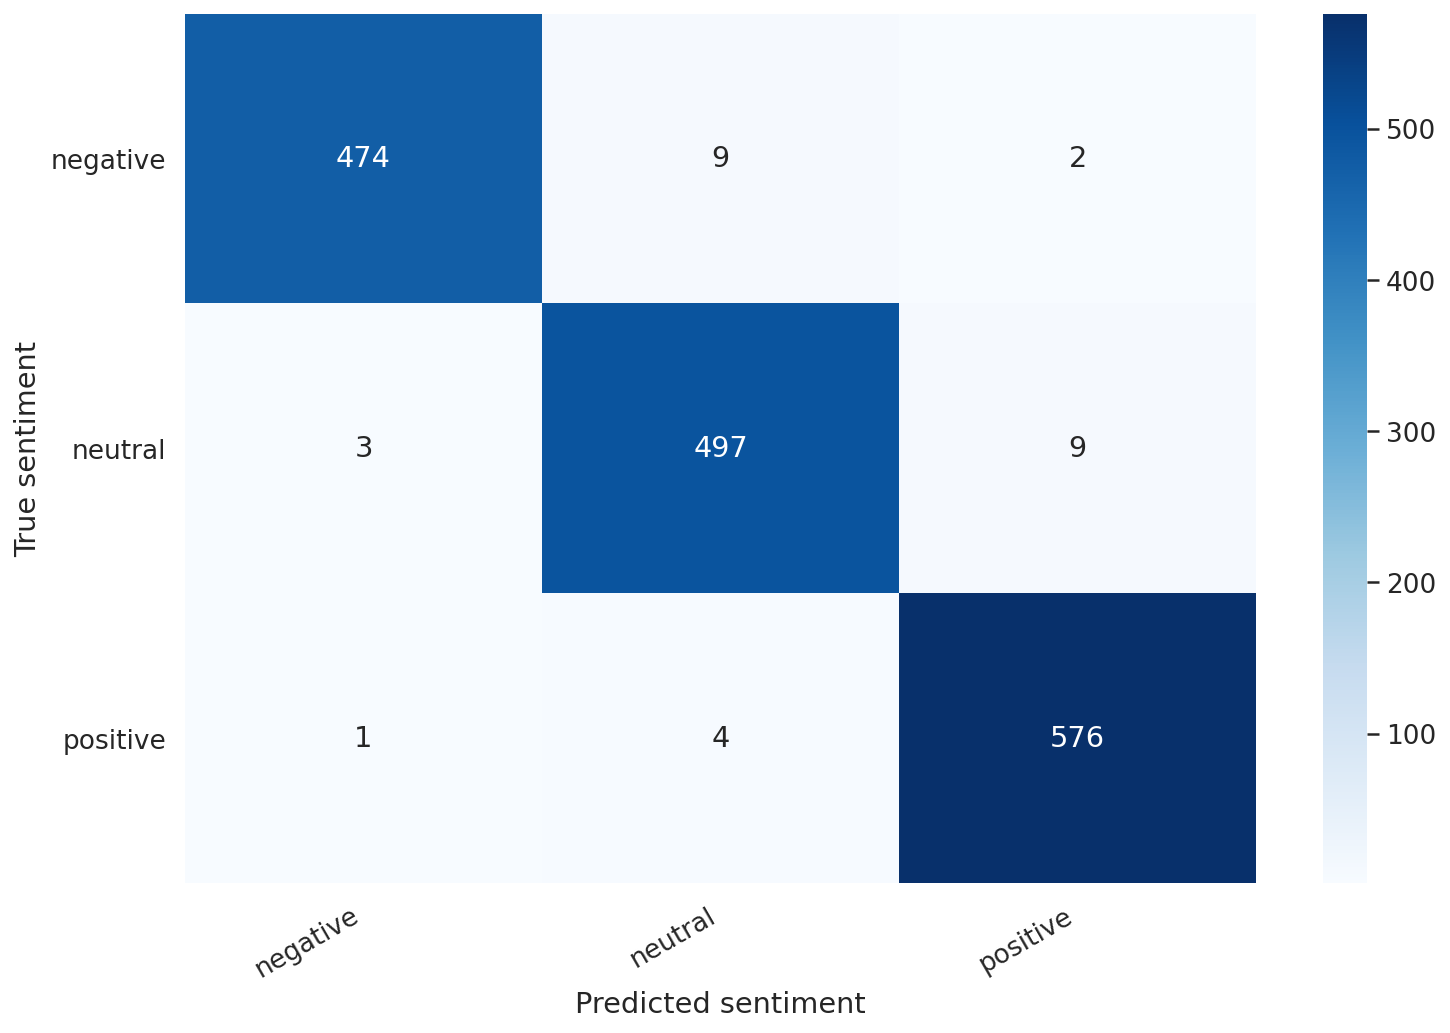

In [107]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [0]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [109]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

It's really good, I would appreciate it even better if I could save
tasks  offline.

True sentiment: neutral


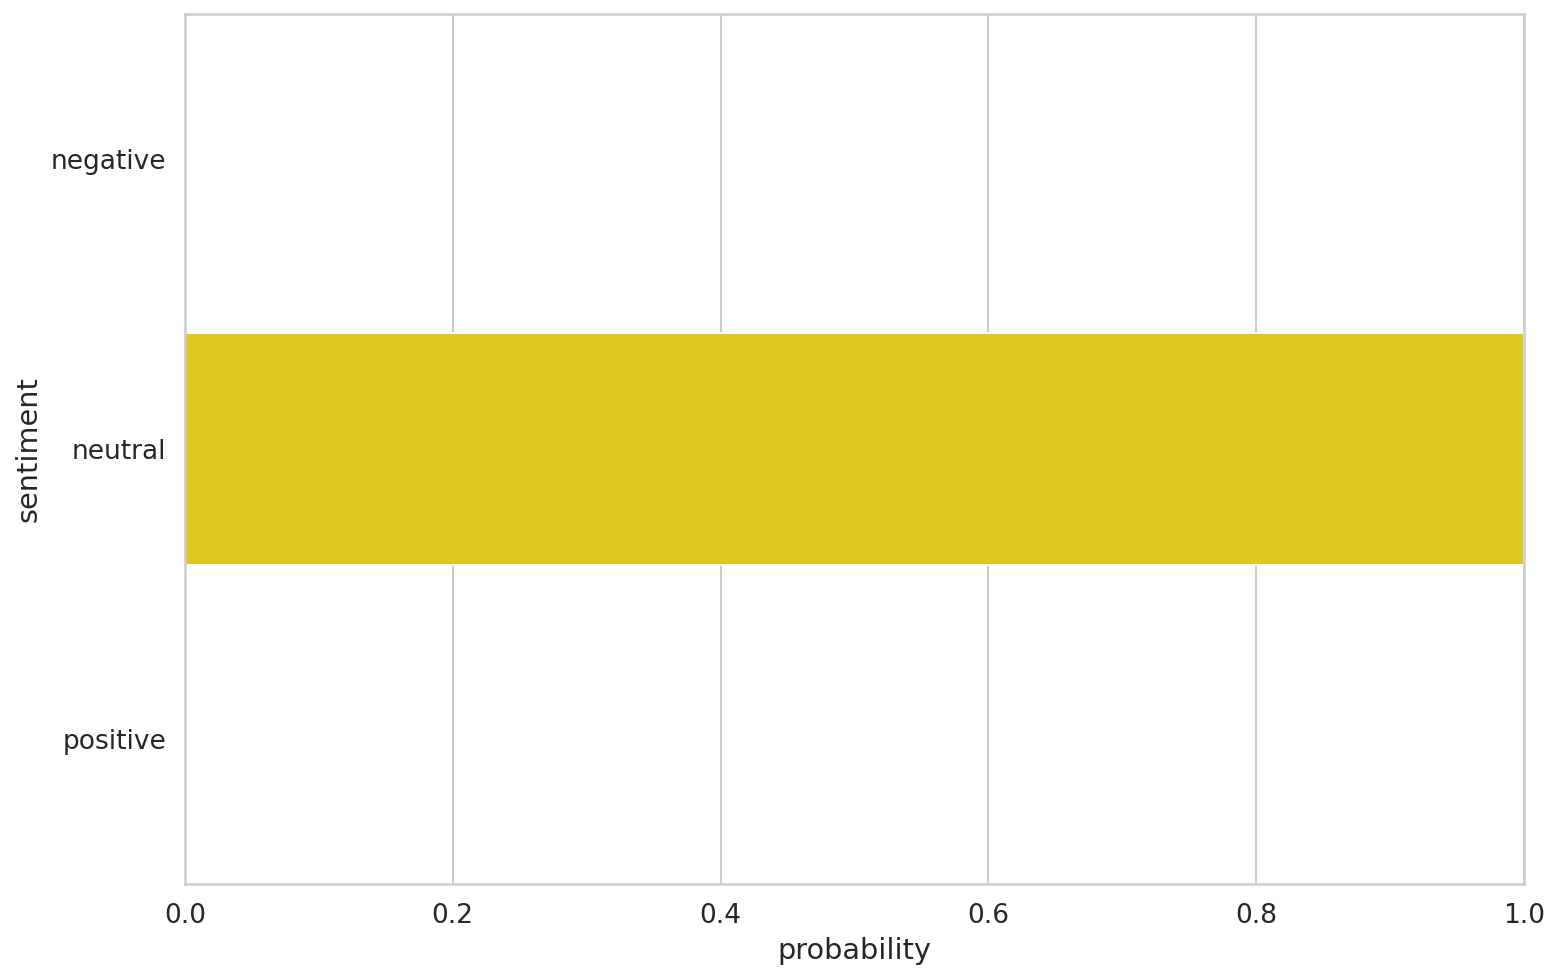

In [110]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicitng on a Raw Text

In [0]:
review_text = "I love completing my todos! Best app ever!!!"

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [113]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
